# Mantenimiento Predictivo

## Resultados

### Prerequisitos

Para este  notebook se necesita installar:

- `os`
- `python == 3.9.7`
- `numpy == 1.23.1`
- `scipy == 1.9.0`
- `matplotlib == 3.5.2`
- `scikit-learn == 1.1.2`
- `joblib == 1.1.0`
- `h5py == 2.7.0`
- `Pillow == 9.2.0`
- `pandas == 1.4.3`
- `TensorFlow == 2.9.1`
- `Keras == 2.9.0`
- `factor-analyzer == 0.4.0`

### Que hace este archivo ?
Este archivo es el paso final del proceso de analis. Se predice  el `RUL` y la `clase de falla` para el conjunto de datos de prueba (test), nasado sobre el entrenamiento previo de una Red Neuronal Recurrente bajo regresion y otro bajo clasificacion binaria(LSTM).

### Cuando se  debe ejecutar este archivo ?

Este archivo extrae la informacion desde la carpeta `..\Data\`. esto requiere el archivo `test.csv`, el cual puede ser creado con el  archivo `Preprocessing.py`. Adicionalmente, se requeire un modelo,  el cual se especifica  su ruta de  carga en la variable  `output_path`, dicho modelo es construido y entrenado en el archivo `traiining.py`( no es necesario ejecutar  este archivo para el reentrenamiento de los modelos, si el conjunto de datos de entreno no ha cambiado)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.models import load_model
import keras.backend as K

from sklearn.preprocessing import SplineTransformer
from sklearn import linear_model

In [2]:
# Path from where to retrieve the model output file
output_path = 'model/regression_model_v1.h5'
sequence_length = 50

In [3]:
test_data = pd.read_csv("Data/test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          13096 non-null  int64  
 1   cycle       13096 non-null  int64  
 2   setting_0   13096 non-null  float64
 3   setting_1   13096 non-null  float64
 4   setting_2   13096 non-null  float64
 5   s_0         13096 non-null  float64
 6   s_1         13096 non-null  float64
 7   s_2         13096 non-null  float64
 8   s_3         13096 non-null  float64
 9   s_4         13096 non-null  float64
 10  s_5         13096 non-null  float64
 11  s_6         13096 non-null  float64
 12  s_7         13096 non-null  float64
 13  s_8         13096 non-null  float64
 14  s_9         13096 non-null  float64
 15  s_10        13096 non-null  float64
 16  s_11        13096 non-null  float64
 17  s_12        13096 non-null  float64
 18  s_13        13096 non-null  float64
 19  s_14        13096 non-nul

In [4]:
# loading the truth data for test ( the real RUL index to each turbine)
result = []
with open('Data/TestSet_RUL.txt', 'r') as file:
    s = file.readlines()
    for i in s:
        result.append(int(i[: -2]))
result = np.array(result)

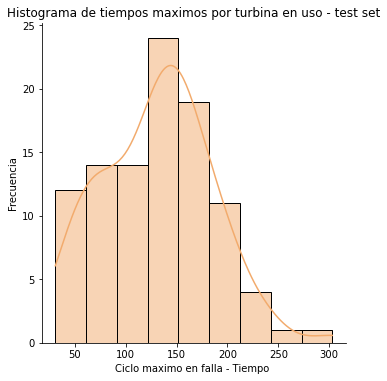

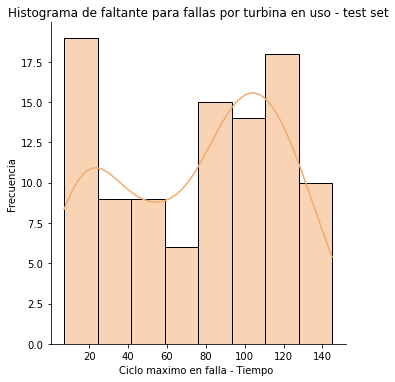

In [5]:
n_test = test_data.shape[0]
n_turb = result.shape[0]

test_end = np.zeros(n_turb)
for i in range(n_turb):
    test_end[i] = test_data[test_data['id'] == (i + 1)].cycle.max()
# hist of executed cycles for each engine in the testing dataset
sns.displot(test_end, color='#F2AB6D',  kde=True) #creamos el gráfico en Seaborn
plt.title('Histograma de tiempos maximos por turbina en uso - test set')
plt.xlabel('Ciclo maximo en falla - Tiempo ')
plt.ylabel('Frecuencia')
plt.show()
sns.displot(result, color='#F2AB6D',  kde=True) #creamos el gráfico en Seaborn
plt.title('Histograma de faltante para fallas por turbina en uso - test set')
plt.xlabel('Ciclo maximo en falla - Tiempo ')
plt.ylabel('Frecuencia')
plt.show()

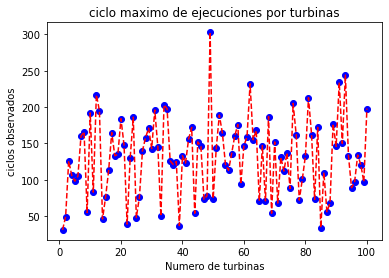

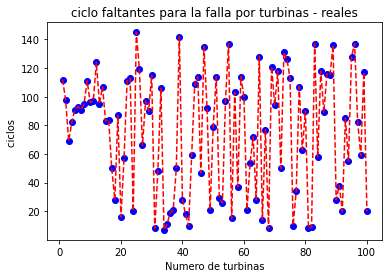

In [6]:
# smooth curve and scatterplot 
spline = SplineTransformer(degree=2, n_knots=4)

x_ = np.array(range(1, n_turb + 1))
X_truth = spline.fit_transform(test_end.reshape(-1,1)) 
X = spline.fit_transform(test_end.reshape(-1,1))
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()
# Entrenamos nuestro modelo
regr.fit(X, test_end )
# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred = regr.predict(X)



plt.figure()
#plt.subplot(1,1,1)
plt.plot(range(1, n_turb + 1), test_end , 'bo')
plt.plot(x_,y_pred,'r--')
plt.xlabel("Numero de turbinas")
plt.ylabel("ciclos observados")
plt.title("ciclo maximo de ejecuciones por turbinas")
plt.show()

#plt.subplot(1,1,1)
plt.plot(range(1, n_turb + 1), result, 'bo')
plt.plot(range(1, n_turb + 1), result,'r--')
plt.xlabel("Numero de turbinas")
plt.ylabel("ciclos ")
plt.title("ciclo faltantes para la falla por turbinas - reales")
plt.show()

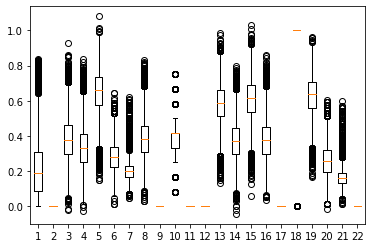

In [7]:
#  boxplot to each sensor 

columns = test_data.columns.difference(['id','cycle','setting_0', 'setting_1', 'setting_2', 'label1', 'label2', 'RUL'])
df = test_data[columns]
descriptive_test = df.describe()

plt.boxplot(df)
plt.show()

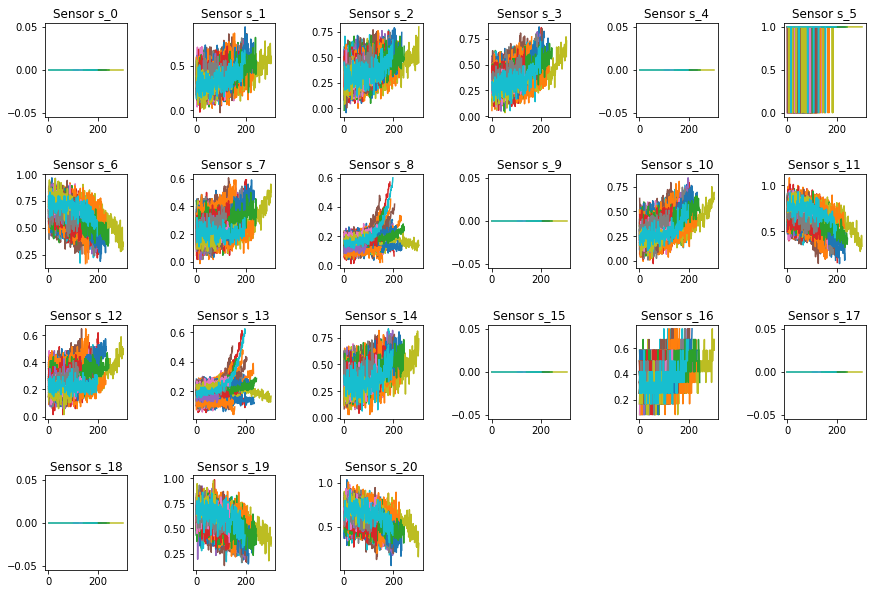

In [8]:
# check the trends over each sensor

df =  test_data.iloc[:, : -4]

def trend_plot(n , data):
    for i in range(1, n):
        k = 1
        plt.figure(1)
        for j in data.columns[5:]:
            plt.subplot(4, 6,k)
            plt.plot(df[df["id"] == i].cycle, df[test_data["id"] == i][j])
            plt.title('Sensor ' + str(j))
            plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.6, wspace=0.8)
            k += 1

n = n_turb + 1
trend_plot(n, df)

In [9]:
cols = ['setting_0','setting_1','s_1','s_2', 's_3', 's_6', 's_7', 's_8','s_10',
       's_11', 's_12', 's_13', 's_14', 's_16', 's_19', 's_20']

corr = df[cols].corr()
corr.style.background_gradient(cmap='coolwarm')

,setting_0,setting_1,s_1,s_2,s_3,s_6,s_7,s_8,s_10,s_11,s_12,s_13,s_14,s_16,s_19,s_20
setting_0,1.000000,-0.007701,0.007159,0.000522,-0.002406,0.000436,0.000401,-0.002734,0.004653,-0.006223,0.011649,-0.008583,0.006341,-0.002448,-0.003114,0.007560
setting_1,-0.007701,1.000000,-0.019323,-0.014673,-0.023242,0.028616,-0.025603,0.016284,-0.031544,0.025507,-0.034281,0.023701,-0.019879,-0.007585,0.007039,0.028477
s_1,0.007159,-0.019323,1.000000,0.387655,0.540813,-0.526991,0.526649,0.025602,0.570150,-0.560245,0.527775,-0.086211,0.496486,0.423478,-0.475045,-0.466920
s_2,0.000522,-0.014673,0.387655,1.000000,0.467417,-0.481640,0.451400,0.072343,0.503727,-0.489609,0.447226,-0.029337,0.427995,0.379133,-0.413866,-0.409713
s_3,-0.002406,-0.023242,0.540813,0.467417,1.000000,-0.650700,0.635391,0.029533,0.687747,-0.675109,0.631043,-0.105956,0.589177,0.517864,-0.577188,-0.562496
s_6,0.000436,0.028616,-0.526991,-0.481640,-0.650700,1.000000,-0.657311,0.029193,-0.694869,0.683309,-0.657077,0.166849,-0.591034,-0.519374,0.569468,0.564581
s_7,0.000401,-0.025603,0.526649,0.451400,0.635391,-0.657311,1.000000,-0.247761,0.684848,-0.685651,0.719693,-0.387148,0.574910,0.494086,-0.561075,-0.561457
s_8,-0.002734,0.016284,0.025602,0.072343,0.029533,0.029193,-0.247761,1.000000,0.007171,0.040933,-0.250171,0.879621,0.032369,0.072248,-0.036146,-0.028295
s_10,0.004653,-0.031544,0.570150,0.503727,0.687747,-0.694869,0.684848,0.007171,1.000000,-0.721503,0.686879,-0.139241,0.628408,0.542143,-0.607503,-0.600496
s_11,-0.006223,0.025507,-0.560245,-0.489609,-0.675109,0.683309,-0.685651,0.040933,-0.721503,1.000000,-0.687172,0.184462,-0.608159,-0.531422,0.591354,0.592179


In [10]:
df = []
for i in test_data.id.unique():
    data_ = test_data[test_data.id == i]
    data_['health_condition'] = data_.RUL / max(data_.RUL)
    df.append(data_)
    
test = pd.concat(df)


C:\Users\DIOSIM~2\AppData\Local\Temp/ipykernel_28936/3588319496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['health_condition'] = data_.RUL / max(data_.RUL)


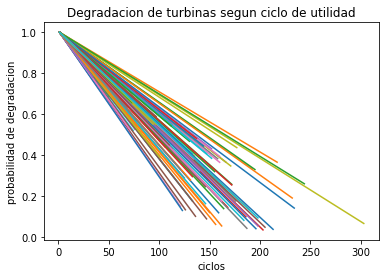

In [11]:
for i in test.id.unique():
    plt.plot(test[test.id == i].cycle, test[test.id ==i].health_condition)
    plt.title('Degradacion de turbinas segun ciclo de utilidad')
    plt.xlabel('ciclos')
    plt.ylabel('probabilidad de degradacion')

## Evaluacion sobre el conjunto de datos de  Test
Se predecira el RUL con la  red nueronal recurrente entrenada previamente

### 1. Forma( dimensiones) de las caracteristicas 
Bajo el mismo razonamiento utilizado en el conjunto de datos de entreno, es necesario  realizar un reescalamiento de la dimensiones de conjunto de datos.

In [12]:
n_turb = test_data['id'].unique().max()

# pick the feature columns 
sensor_cols = ['s_' + str(i) for i in range(0,21)]
sequence_cols = ['setting_0', 'setting_1', 'setting_2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_data[test_data['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in range(1, n_turb + 1) if len(test_data[test_data['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

print("Esta es el perfil del conjunto de datos: {} turbinas(motores), {} ciclos y {} caracteristicas.".format(
    seq_array_test_last.shape[0], seq_array_test_last.shape[1], seq_array_test_last.shape[2]))

print("Hay solo {} tuebinas de {} ya que {} turbinas no tenían más de {} ciclos.".format(
    seq_array_test_last.shape[0], n_turb, n_turb - seq_array_test_last.shape[0], sequence_length))

Esta es el perfil del conjunto de datos: 93 turbinas(motores), 50 ciclos y 25 caracteristicas.
Hay solo 93 tuebinas de 100 ya que 7 turbinas no tenían más de 50 ciclos.


### 2.  Seleccionar y re estrucutrar la dimension de las etiquetas

Del mismo modo, seleccionamos las etiquetas.

In [13]:
y_mask = [len(test_data[test_data['id']==id]) >= sequence_length for id in test_data['id'].unique()]
label_array_test_last = test_data.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

### 3. Prediccion de RUL  para el conjunto de datos de  test

In [19]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# if best iteration's model was saved then load and use it
if os.path.isfile(output_path):
    estimator = load_model(output_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nLoss: {}'.format(scores_test[0]))
    print('\nRMSE: {}'.format(scores_test[1]))
    print('\nMAE: {}'.format(scores_test[2]))
    
    s1 = ((y_pred_test - y_true_test)**2).sum()
    moy = y_pred_test.mean()
    s2 = ((y_pred_test - moy)**2).sum()
    s = 1 - s1/s2
    print('\nEficiencia: {}%'.format(s * 100))
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(y_true_test, y_pred_test )
    print('\nMAPE: {}%'.format(mape))
    
    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('output/submit_test.csv', index = None)

3/3 - 1s - loss: 217.3996 - root_mean_squared_error: 14.7445 - mae: 10.3345 - 1s/epoch - 418ms/step

Loss: 217.39956665039062

RMSE: 14.744475364685059

MAE: 10.334512710571289

Eficiencia: 87.41124123334885%

MAPE: 13.904403150081635%


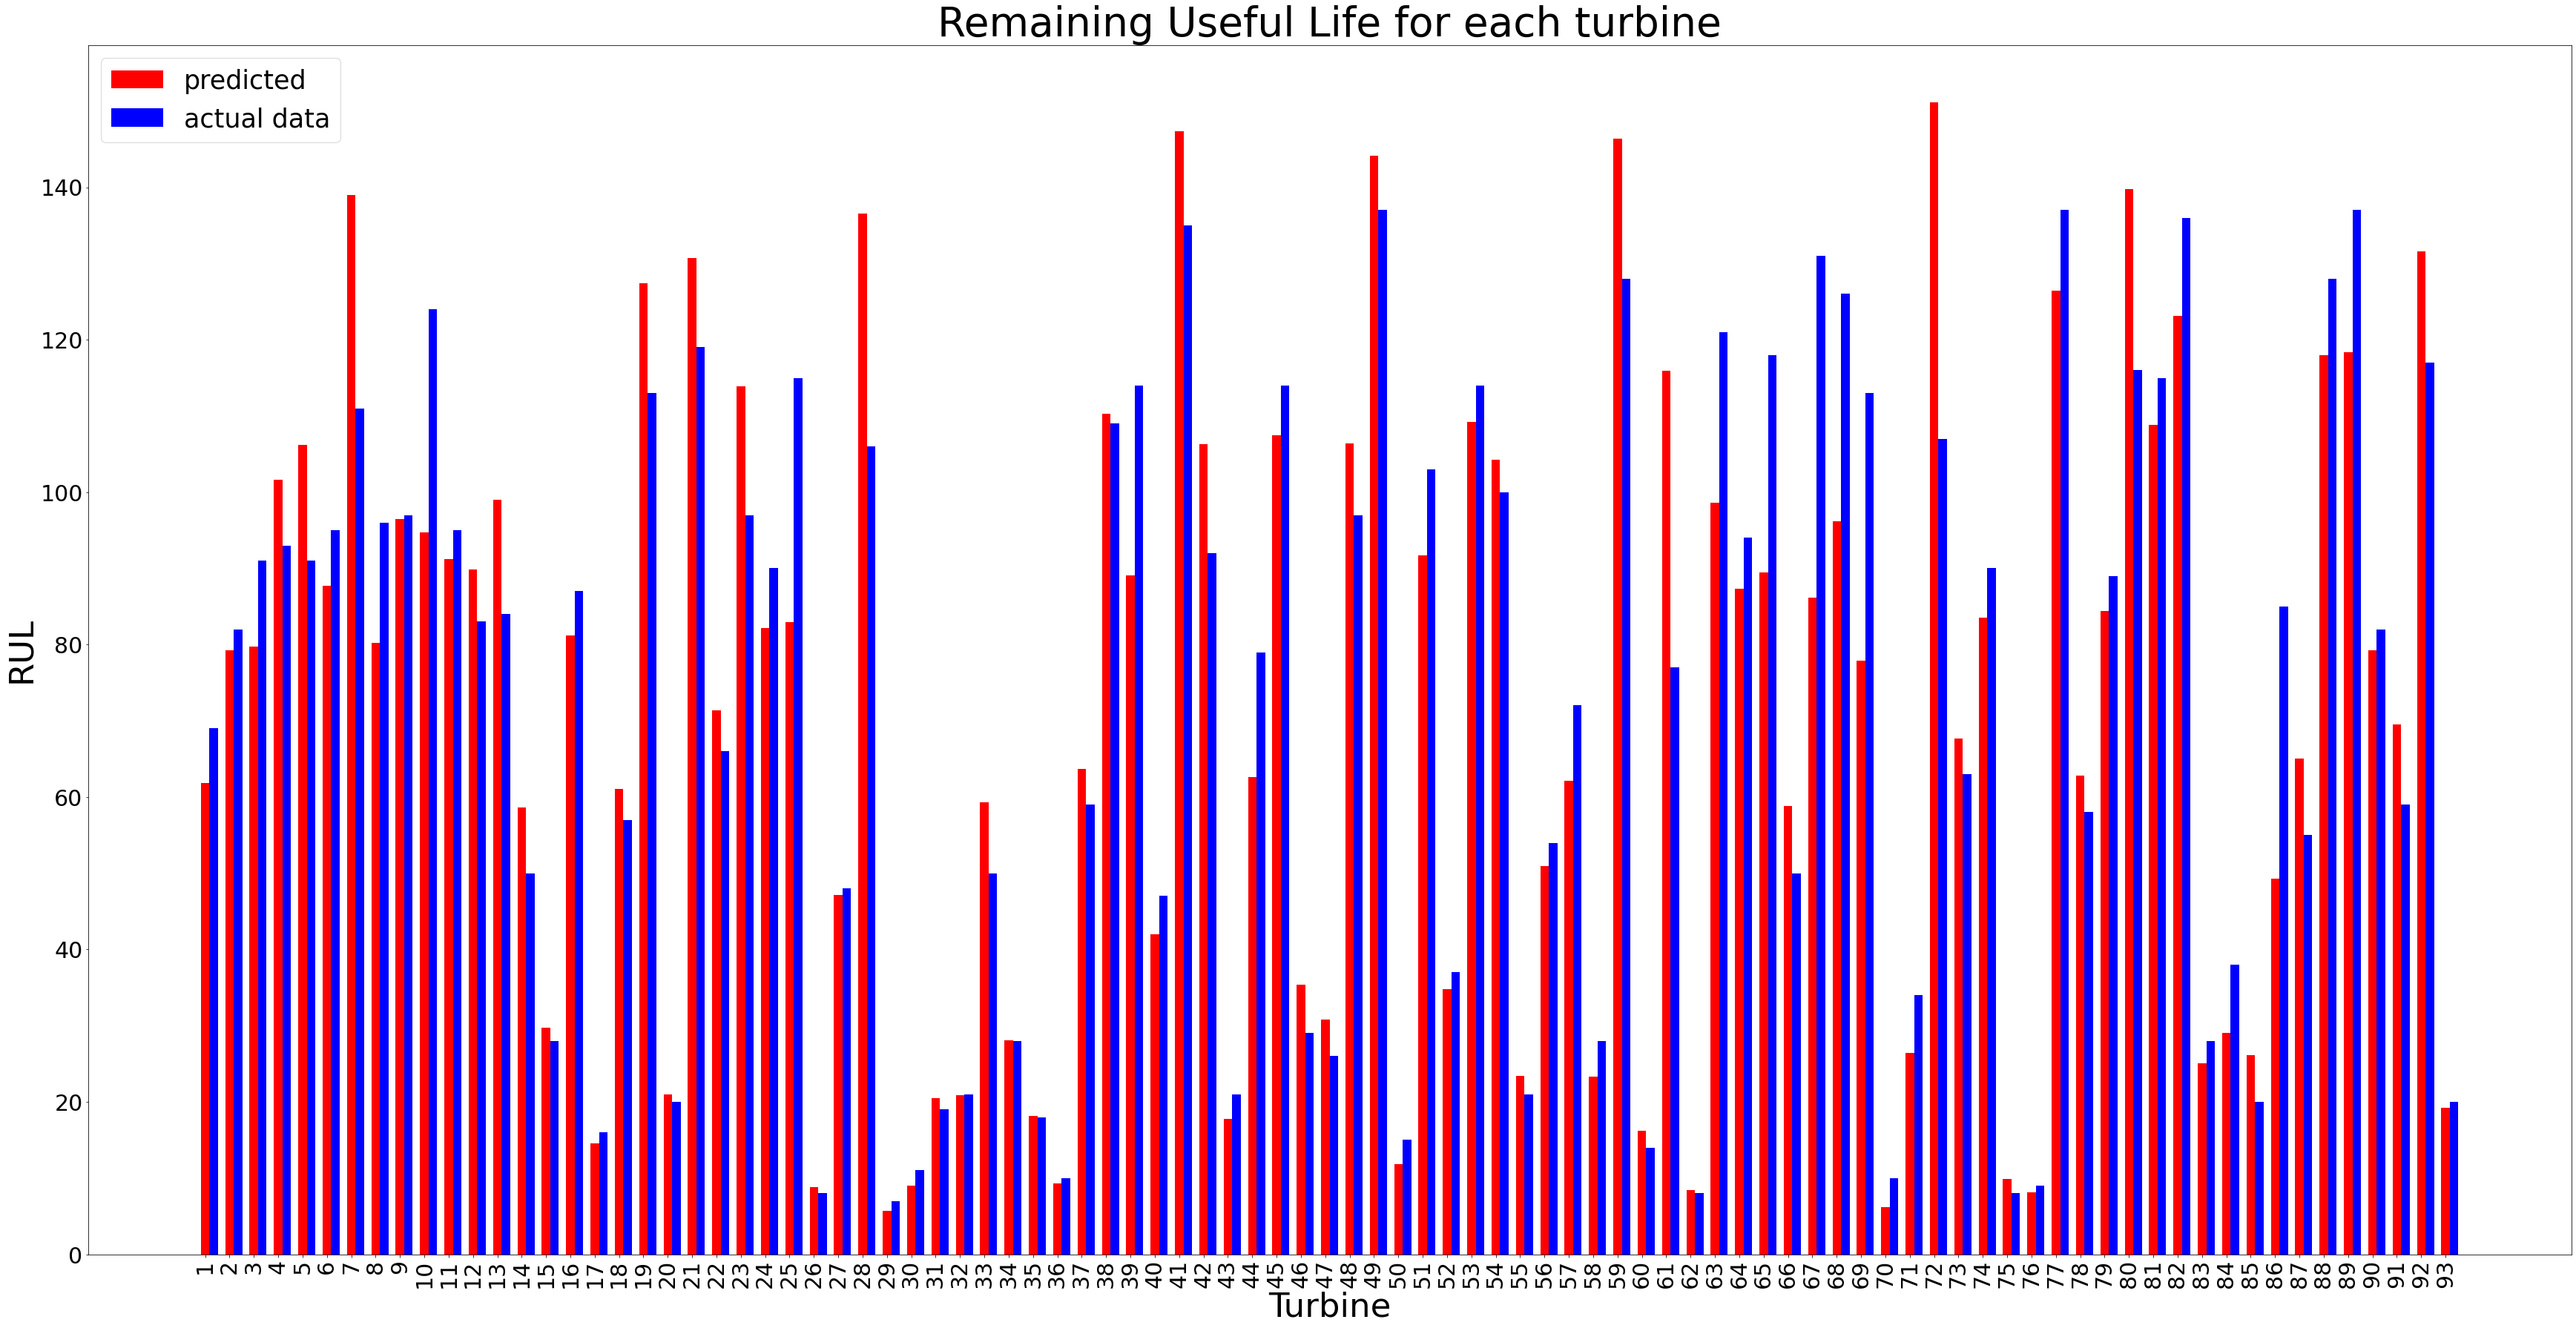

In [36]:
if os.path.isfile(output_path):
    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(60, 30))
    # plt.plot(y_pred_test, 'ro', color="red", lw=3.0)
    # plt.plot(y_true_test, 'ro', color="blue")
    X = np.arange(1, 94)
    width = 0.35
    plt.bar(X, np.array(y_pred_test).reshape(93,), width, color='r')
    plt.bar(X + width, np.array(y_true_test).reshape(93,), width, color='b')
    plt.xticks(X, fontsize=30, rotation=90)
    plt.yticks( fontsize=30)
    plt.title('Remaining Useful Life for each turbine', fontsize=55)
    plt.ylabel('RUL', fontsize=45)
    plt.xlabel('Turbine', fontsize=45)
    plt.legend(['predicted', 'actual data'], loc='upper left', fontsize=35)
    plt.show()
    fig_verify.savefig("output/model_regression_verify.png")